In [1]:
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal

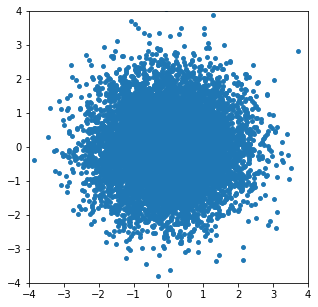

In [2]:
n_sample = 10000
target_dist = MultivariateNormal(torch.zeros(2), torch.eye(2))
sampled_z = target_dist.sample((n_sample,))
plt.figure(figsize = (5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(sampled_z[:,0], sampled_z[:,1], s=15)

In [3]:
def doublemoon_sample(n_sample):
    x1_1 = Normal(4, 4)
    sampled_x1_1 = x1_1.sample((int(n_sample/2),))
    x2_1 = Normal(0.25*(sampled_x1_1-4)**2-20, torch.ones_like(sampled_x1_1)*2)
    sampled_x2_1 = x2_1.sample()

    x1_2 = Normal(-4, 4)
    sampled_x1_2 = x1_2.sample((int(n_sample/2),))
    x2_2 = Normal(-0.25*(sampled_x1_2+4)**2+20, torch.ones_like(sampled_x1_2)*2)
    sampled_x2_2 = x2_2.sample()

    sampled_x1 = torch.cat([sampled_x1_1, sampled_x1_2])
    sampled_x2 = torch.cat([sampled_x2_1, sampled_x2_2])
    sampled_x = torch.zeros(n_sample, 2)
    sampled_x[:,0] = sampled_x1*0.2
    sampled_x[:,1] = sampled_x2*0.1
    
    return sampled_x

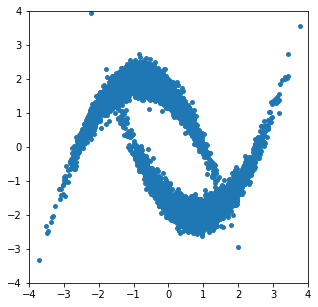

In [4]:
sampled_x = doublemoon_sample(n_sample)
plt.figure(figsize = (5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(sampled_x[:,0],sampled_x[:,1], s=15)

In [5]:
import torchflow

net = torchflow.model.real_nvp(4, 2, 256)
if torch.cuda.is_available():
    net.cuda()
    torchflow.distribution.cuda_(target_dist)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [6]:
n_epochs = 500
n_batch = 512
for epoch in range(n_epochs):
    running_loss = 0
    optimizer.zero_grad()
    x = doublemoon_sample(n_batch)
    if torch.cuda.is_available():
        x = x.cuda()
    z, log_det_jacobian = net(x)
    loss = -(target_dist.log_prob(z).sum() + log_det_jacobian) / n_batch
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print('epoch:[%2d/%2d] loss:%1.4f' % (epoch+1, n_epochs, loss.item()))

epoch:[50/500] loss:3.5186
epoch:[100/500] loss:2.1883
epoch:[150/500] loss:1.9744
epoch:[200/500] loss:1.8740
epoch:[250/500] loss:1.7970
epoch:[300/500] loss:1.7174
epoch:[350/500] loss:1.8029
epoch:[400/500] loss:1.9459
epoch:[450/500] loss:1.7920
epoch:[500/500] loss:1.9317


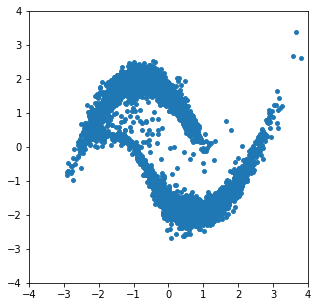

In [7]:
with torch.no_grad():
    new_sampled_z = target_dist.sample((5000,))
    predicted_x = net.inverse(new_sampled_z)[0].cpu()
plt.figure(figsize = (5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(predicted_x[:,0], predicted_x[:,1], s=15)

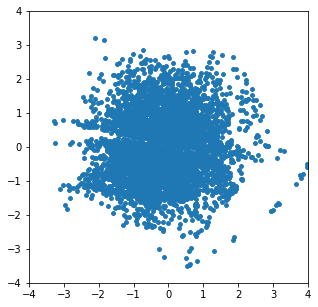

In [8]:
with torch.no_grad():
    new_sampled_x = doublemoon_sample(5000)
    if torch.cuda.is_available:
        new_sampled_x = new_sampled_x.to("cuda")
    predicted_z = net(new_sampled_x)[0].cpu()
plt.figure(figsize = (5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(predicted_z[:,0], predicted_z[:,1], s=15)